# Поиск изображения по контенту (CBIR)

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Алгоритм вычисления дескриптора изображения

In [2]:
class ColorDescriptor:
    
    def __init__(self, bins):
        # количество сегментов по y, x и channel
        self.bins = bins
 
    def describe(self, image):
        """ Вычисляем дескриптор изображения """
        
        features = []  # результирующий вектор дескриптора
        
        # переводим исходное изображение из цветового пространства BGR в HSV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 
        (h, w) = image.shape[:2]  # размеры изображения
        (cX, cY) = (int(w * 0.5), int(h * 0.5))  # координаты центра изображения
        
        # делим изображение на четыре равные части
        # и вычисляем координаты сегментов
        segments = [(0, cX, 0, cY), 
                    (cX, w, 0, cY),
                    (cX, w, cY, h),
                    (0, cX, cY, h)]
 
        # готовим маску в виде эллипса для выделения 
        # дескрипторов центральной части изображения
        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellip_mask = np.zeros(image.shape[:2], dtype = np.uint8)
        cv2.ellipse(ellip_mask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
 
        # итерируем по четырем сегментам и вычисляем дескрипторы
        for (startX, endX, startY, endY) in segments:
            # формируем маску сегмента
            corner_mask = np.zeros(image.shape[:2], dtype = np.uint8)
            cv2.rectangle(corner_mask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(corner_mask, ellip_mask)  # вычитаем пересечение с эллипсом 
 
            # строим цветовую гистограмму с учетом маски сегмента
            hist = self.histogram(image, corner_mask)
            features.extend(hist)
 
        # вычисляем гистограму для центральной области
        hist = self.histogram(image, ellip_mask)
        features.extend(hist)
 
        # возвращаем вектор полученный вектор дескрипторов
        return features
    
    def histogram(self, image, mask):
        """ Вычисляет гистограмму в области, заданной маской """
        
        # задаем диапазоны изменений по каналам
        ranges = [0, 180,  # Hue
                  0, 256,  # Saturation
                  0, 256]  # Value
        
        # вычисляем 3D гистограмму (x, y, channel)
        hist = cv2.calcHist([image], [0, 1, 2], mask,
                            self.bins, ranges = ranges)
        
        # нормируем гистограмму
        hist = cv2.normalize(hist, np.zeros_like(hist)).flatten()

        return hist

## Вычисляем дескрипторы для базы изображений

In [3]:
import glob

index = []   # имена фалов
index_features = []  # дескрипторы изображений

# получаем список файлов для индексации
files = list(glob.glob('./data/inria/*.jpg'))

# инициализируем объект для вычисления дескрипторов
cd = ColorDescriptor((8, 12, 3))

for path in files[:25]:
    # сохраняем идентификатор изображения в массив
    image_id = path[path.rfind('/') + 1:]
    index.append(image_id)

    # загружаем изображение
    image = cv2.imread(path)
    
    # вычисляем и сохраняем дескрипторы
    features = cd.describe(image)
    index_features.append(features)

index_features = np.array(index_features)

In [4]:
index_features.shape

(12, 1440)

## Определяем меру расстояния между дескрипторами

In [5]:
def chi2_distance(histA, histB, eps = 1e-10):
    # мера расстояния chi-квадрат
    d = 0.5 * np.sum([((a - b) ** 2) # / (a + b + eps)
                      for (a, b) in zip(histA, histB)])
    return d

In [6]:
def rank(query_features, index_features):
    # вычисляем расстояние до изображения из базы
    result = np.zeros(len(index_features))
    for i in range(len(index_features)):
        result[i] = chi2_distance(query_features, index_features[i])
    return result

## Формируем запрос и выводим похожие изображения

In [7]:
# загружаем изображение для поиска похожих
query = cv2.imread('./data/inria/105000_sm.jpg')

# получаем фичи для изображения запроса
query_features = cd.describe(query)

# ранжируем резльтат с учетом метрики расстояния
distance = rank(query_features, index_features)

# сортируем индексы по расстоянию
indices = np.argsort(distance)

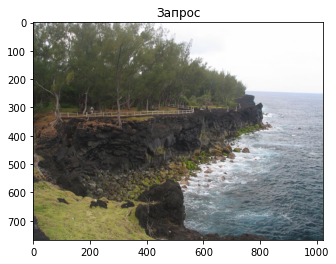

In [8]:
# изображение запроса
plt.imshow(cv2.cvtColor(query, cv2.COLOR_BGR2RGB))
plt.title('Запрос');

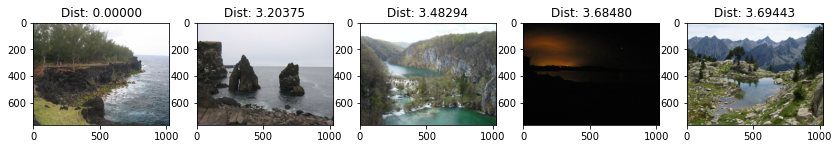

In [9]:
# выводим топ 5 самых близких изображений
fig = plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    img = cv2.imread(files[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Dist: %.5f' % distance[idx])